#**Imersão Dados - Desafio Final**

## **INTRODUÇÃO**

### **Drug Discovery**
Considerando o árduo processo de investigação de novos compostos e os custos milionários de pesquisa e desenvolvimento para a criação de uma nova droga, a ciência de dados propõe o machine learning e deep learning como ferramentas que possam viabilizar, sob outros parâmetros, descobertas e análises dessa área de bioinformática ([Gulati](https://medium.com/analytics-vidhya/the-rise-of-machine-learning-in-drug-discovery-f5dc4ac1005f), 2021). 

### **Dados**
Este desafio baseia-se em dados do projeto Connectivity MAP lançados numa competição lançada no [Kaggle](https://www.kaggle.com/c/lish-moa/overview) por parte do Laboratório de Ciência e Inovação de Havard. As variáveis disponíveis na base de dados contém a identificação da cultura celular, o composto utilizado, a dose aplicada, o período de análise e os resultados com relação a expressão genética e viabilidade celular. Outra base que compõe nosso framework trata dos resultados encontrados, em termos mais específicos, o mecanismo de ação (inibidores, antagonistas, agonistas, bloqueadores, ativadores, etc.) que é ativado sob as características da primeira tabela. A competição buscava construir um modelo de aprendizado de máquina para prever o mecanismo de ativação de drogas desconhecidas.

As características da expressão genética (g) se dão a partir da mistura de 100 linhas de células selecionadas que posteriormente são expostaa a ação de um composto. Após o período de 24 horas, a informação presente no RNA é coletado e isolado da cultura e assim é feito para 772 genes selecionados. Além da análise das 772 expressões genéticas, são fornecidos 100 linhas celulares que tratam da viabilidade celular (c), ou seja, o número de células sobreviventes dentro de cada uma das culturas em análise (a razão entre o número de células viáveis e o número total de células). Já os resultados em análise tratam-se dos mecanismos de ação, isto é, a interação bioquímica que após a introdução de um composto produz um efeito farmacológico. De forma leiga, podemos dizer que é a função do princípio ativo na célula. A base é composta de 206 especificações para o mecanismo de ação com resultados binários para cada id. Simplificando, são resultados baseados em 0 e 1, onde 1 indica qual mecanismo de ação foi ativado (podendo ser nenhum, um ou mais) para cada cultura celular(id). 

A ideia de Machine Learning aliada ao processo de descoberta de novas drogas se dá pela possibilidade de um modelo computacional predizer o mecanismo de ação que pode ser ativado caso possua informações sobre a expressão gênica e viabilidade celular. Quanto mais variáveis tem-se no modelo e quão mais complexo é o problema a ser resolvido, adentramos em campos mais profundos da bioinformática, abrindo espaço para se explorar ferramentas de Deep Learning no intuito de focar em tarefas multirótulo. 

## **PROJETO**

Sabemos que o processo de *drug discovery* é longo e dispendioso, podendo chegar a milhões em recursos utilizados para que uma droga chegue às farmácias. Durante as aulas acompanhamos o processo e tentar ao final, criar um modelo de predição do número de mecanimos de ação ativados com base nos experimentos realizados(você pode ter acesso ao notebook das Aulas 01 a 05 [aqui](https://github.com/lucasnascm/ImersaoDados_Bioinformatica/blob/main/Aulas_01_05.ipynb)). 

Uma variável que temos na base dos dados é a dose - D1 e D2 - que significa se a cultura celular recebeu uma baixa ou alta dose do composto, respectivamente. Sabendo dos custos envolvidos no processo, o tempo de análise até seguir para a etapa de ensaios clínicos e ainda, o preço do remédio repassado ao consumidor, entre outros, são fatores que nos levam a pensar na melhor maneira de administrar todos estes recursos. Considerando  **A pergunta que nós queremos responder aqui é: 1 dose bastaria?**

In [ ]:
#importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#fonte dos dados
url_dados = 'https://github.com/alura-cursos/imersaodados3/blob/main/dados/dados_experimentos.zip?raw=true'

#leitura do arquivo
dados = pd.read_csv(url_dados, compression = 'zip')
#cabeçalho do df - primeiras cinco observações
dados.head()

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [ ]:
#informações do dataframe
print(dados.shape)

(23814, 877)


In [ ]:
#renomeando colunas
dados.columns = dados.columns.str.lower().str.replace('-', '')
dados.rename(columns={'droga':'composto'}, inplace=True)

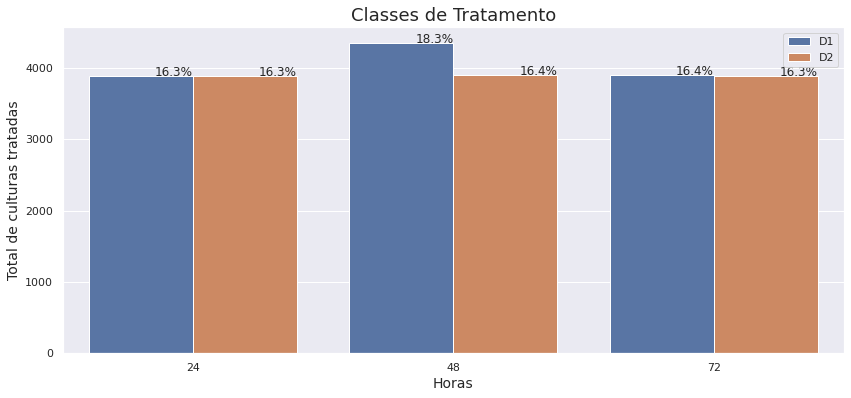

In [ ]:
sns.set()

classes = sns.countplot(data=dados, x='tempo', hue='dose')
classes.figure.set_size_inches(14,6)
classes.set_title('Classes de Tratamento', fontsize = 18)
classes.set_xlabel('Horas', fontsize = 14)
classes.set_ylabel('Total de culturas tratadas', fontsize = 14)
classes.legend(loc = 'best')

total = float(len(dados))
for p in classes.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    classes.annotate(percentage, (x, y), ha='right')

classes

In [ ]:
#aqui criamos duas bases: d1 que possui apenas observações de experimentos de baixa dose e d2 que contém só observações de alta dose
d1 = dados.query('dose == "D1"')
d2 = dados.query('dose == "D2"')

In [ ]:
#total de culturas ditribuídas no tempo, que foram introduzidas com D1 ou D2
pd.crosstab(dados['dose'], dados['tempo'])

tempo,24,48,72
dose,,,
D1,3886,4354,3907
D2,3886,3896,3885


Aqui já conseguimos visualizar que a proporção de culturas com apenas a D1 é maior em relação a D2 (existem 480 experimentos a mais com baixa dose). **Mas uma outra pergunta importante e que impacta na nossa avaliação é se, por ventura, o número de Mecanimos de Ação ativados na base de resultados em D2 é maior**, uma vez que a dose maior pode provocar mais interações e efeitos na cultura celular.

In [ ]:
#fonte dos dados dos resultados
resultados = pd.read_csv('https://github.com/alura-cursos/imersaodados3/blob/main/dados/dados_resultados.csv?raw=true')
resultados.head()

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#total de MoAs ativados por variável
dados_moa = resultados.drop('id', axis=1).sum().sort_values(ascending=False).reset_index()
dados_moa.columns = ['MOA', 'quantidade']
dados_moa

,MOA,quantidade
0,nfkb_inhibitor,832
1,proteasome_inhibitor,726
2,cyclooxygenase_inhibitor,435
3,dopamine_receptor_antagonist,424
4,serotonin_receptor_antagonist,404
...,...,...
201,protein_phosphatase_inhibitor,6
202,autotaxin_inhibitor,6
203,diuretic,6
204,erbb2_inhibitor,1


In [ ]:
#criação de uma lista que classifica os diferentes tipos de Mecanimos de Ação
acao_moa = []
moa_sep = dados_moa['MOA'].str.split('_')
for row in moa_sep:
    acao_moa.append(row[-1])
dados_moa['acao'] = acao_moa
dados_moa.head()

,MOA,quantidade,acao
0,nfkb_inhibitor,832,inhibitor
1,proteasome_inhibitor,726,inhibitor
2,cyclooxygenase_inhibitor,435,inhibitor
3,dopamine_receptor_antagonist,424,antagonist
4,serotonin_receptor_antagonist,404,antagonist


In [ ]:
#cria uma variável com o número de moas ativados pelos experimentos em cada observação
resultados['n_moa'] = resultados.drop('id', axis=1).sum(axis=1)
resultados['n_moa'] != 0
#classifica em True resultados maiores que zero, False caso contrário (var booleana)
resultados['atv_moa'] = (resultados['n_moa'] != 0)
resultados.head()

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,n_moa,atv_moa
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,True
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True


In [ ]:
#merge dos resultados com os dados de D1 e D2
resultados_dados = dados.merge(resultados[['id', 'n_moa', 'atv_moa']], how='inner', on='id')
resultados_d1 = d1.merge(resultados[['id', 'n_moa', 'atv_moa']], how='inner', on='id')
resultados_d2 = d2.merge(resultados[['id', 'n_moa', 'atv_moa']], how='inner', on='id')

Depois de juntar a coluna do número de mecanismos de ação ativados (que podem ser até 7 para um único composto), além da coluna criada que mostra se há ativação com um simples True/False (ideal para os testes de Machine Learning adiante) com a nossa base de D1 e D2. Nos gráficos abaixo, entendemos que já em D1 a proporção de mecanismos ativados, em comparação com os mecanismos ativados em D2 são relativamente iguais, onde mais da metade de ambas as bases apresentam 1 MoA ativado. A partir de 3 MoAs ativados, a revelância dos dados já não é significativa. Ainda, são apresentados as estatísticas descritivas para cada base (Base Completa, Base D1, Base D2) para deixar claro que os resultados de tempo e n_moa se assemelham entre si.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


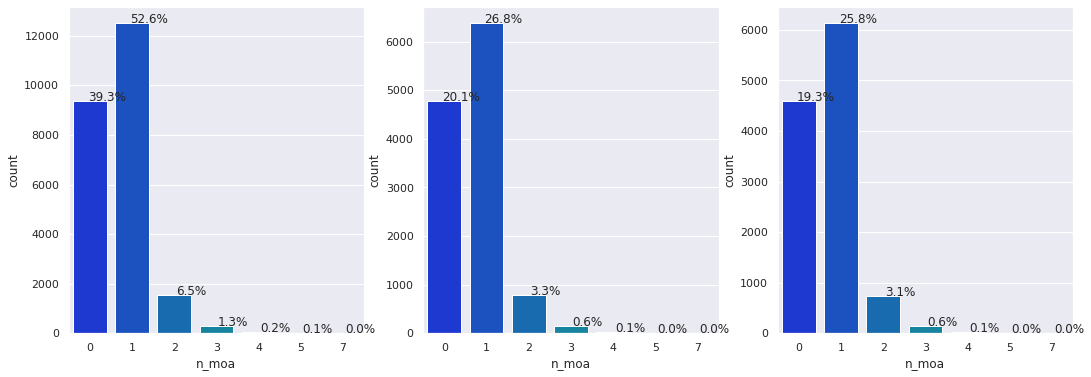

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

ax1 = sns.countplot(resultados_dados['n_moa'], ax=ax[0])
totald = float(len(resultados_dados))
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/totald)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax1.annotate(percentage, (x, y), ha='center')

ax2 = sns.countplot(resultados_d1['n_moa'], ax=ax[1])
totald1 = float(len(resultados_d1))
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/totald)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax2.annotate(percentage, (x, y), ha='center')

ax3 = sns.countplot(resultados_d2['n_moa'], ax=ax[2])
totald2 = float(len(resultados_d2))
for p in ax3.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/totald)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax3.annotate(percentage, (x, y), ha='center')

fig.show()

In [ ]:
resultados_dados.describe().T

,count,mean,std,min,25%,50%,75%,max
tempo,23814.0,48.020156,19.402807,24.000,24.000000,48.00000,72.000000,72.000
g0,23814.0,0.248366,1.393399,-5.513,-0.473075,-0.00885,0.525700,10.000
g1,23814.0,-0.095684,0.812363,-5.737,-0.562200,-0.04660,0.403075,5.039
g2,23814.0,0.152253,1.035731,-9.104,-0.437750,0.07520,0.663925,8.257
g3,23814.0,0.081971,0.950012,-5.998,-0.429575,0.00805,0.463400,10.000
...,...,...,...,...,...,...,...,...
c96,23814.0,-0.463485,2.059725,-10.000,-0.552575,-0.00125,0.465225,3.505
c97,23814.0,-0.378241,1.703615,-10.000,-0.561000,-0.00680,0.446400,2.924
c98,23814.0,-0.470252,1.834828,-10.000,-0.592600,0.01400,0.461275,3.111
c99,23814.0,-0.301505,1.407918,-10.000,-0.562900,-0.01950,0.438650,3.805


In [ ]:
resultados_d1.describe().T

,count,mean,std,min,25%,50%,75%,max
tempo,12147.0,48.041492,19.224096,24.000,24.00000,48.0000,72.00000,72.000
g0,12147.0,0.312476,1.511533,-5.420,-0.48305,-0.0003,0.56865,10.000
g1,12147.0,-0.176353,0.829120,-5.737,-0.64420,-0.0828,0.38205,3.954
g2,12147.0,0.250972,0.980866,-5.666,-0.38590,0.1119,0.70870,6.433
g3,12147.0,0.062657,0.766310,-3.482,-0.37305,0.0179,0.43310,7.645
...,...,...,...,...,...,...,...,...
c96,12147.0,-0.516180,2.161967,-10.000,-0.56245,0.0052,0.47340,3.167
c97,12147.0,-0.418721,1.796350,-10.000,-0.57585,0.0001,0.44870,2.751
c98,12147.0,-0.527623,1.923930,-10.000,-0.63920,0.0133,0.46050,3.111
c99,12147.0,-0.337724,1.514677,-10.000,-0.56900,-0.0136,0.45025,3.120


In [ ]:
resultados_d2.describe().T

,count,mean,std,min,25%,50%,75%,max
tempo,11667.0,47.997943,19.587937,24.000,24.00000,48.0000,72.00000,72.000
g0,11667.0,0.181619,1.255269,-5.513,-0.46340,-0.0165,0.48250,10.000
g1,11667.0,-0.011696,0.785827,-3.364,-0.49100,-0.0155,0.42770,5.039
g2,11667.0,0.049474,1.080423,-9.104,-0.50495,0.0381,0.61705,8.257
g3,11667.0,0.102081,1.109086,-5.998,-0.49090,-0.0015,0.50445,10.000
...,...,...,...,...,...,...,...,...
c96,11667.0,-0.408623,1.946159,-10.000,-0.54180,-0.0075,0.45510,3.505
c97,11667.0,-0.336096,1.600359,-10.000,-0.54975,-0.0144,0.44150,2.924
c98,11667.0,-0.410521,1.735279,-10.000,-0.54900,0.0147,0.46160,2.627
c99,11667.0,-0.263796,1.286375,-9.155,-0.55860,-0.0257,0.42550,3.805


Posto isto, podemos pensar que os experimentos de D1 já seriam suficientes para uma boa análise (uma vez que os mecanismos de ação já estão ativados). **Agora, resta-nos saber: a base com apenas D1 resultaria em um bom modelo de predição?**.

In [ ]:
#importar bibliotecas de machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

A seguir, estabelecemos diferentes testes para medir a acurácia do nosso modelo e colocarmos sob perspectiva todos eles, para tentarmos entender se com a base de dados reduzida (D1 e/ou D2), a acurácia diminui em relação aos modelos que utilizam da base completa.

#### **1. Regressão Logística**

In [ ]:
#base completa
a = resultados_dados.select_dtypes('float64')
b = resultados_dados['atv_moa']
a_treino, a_teste, b_treino, b_teste = train_test_split(a, b, test_size = 0.2, stratify=b, random_state=376)

modelo_rlogistica = LogisticRegression(max_iter=1000, C=1.5)
modelo_rlogistica.fit(a_treino, b_treino)
modelo_rlogistica.score(a_teste, b_teste)

0.6260760025194205

In [ ]:
#base de D1
x = resultados_d1.select_dtypes('float64')
y = resultados_d1['atv_moa']
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=376)

modelo_rlogistica = LogisticRegression(max_iter=1000, C=1.5)
modelo_rlogistica.fit(x_treino, y_treino)
modelo_rlogistica.score(x_teste, y_teste)

0.6176954732510288

In [ ]:
#base de D2
z = resultados_d2.select_dtypes('float64')
w = resultados_d2['atv_moa']
z_treino, z_teste, w_treino, w_teste = train_test_split(z, w, test_size = 0.2)

modelo_rlogistica = LogisticRegression(max_iter=1000, C=1.5)
modelo_rlogistica.fit(z_treino, w_treino)
modelo_rlogistica.score(z_teste, w_teste)

0.6186803770351328

#### **2. Dummy Classifier**

In [ ]:
#base completa
modelo_dummy_ab = DummyClassifier('most_frequent')
modelo_dummy_ab.fit(a_treino, b_treino)
previsao_dummy_ab = modelo_dummy_ab.predict(a_teste)
accuracy_score(b_teste, previsao_dummy_ab)

0.6067604450976275

In [ ]:
#base de D1
modelo_dummy_xy = DummyClassifier('most_frequent')
modelo_dummy_xy.fit(x_treino, y_treino)
previsao_dummy_xy = modelo_dummy_xy.predict(x_teste)
accuracy_score(y_teste, previsao_dummy_xy)

0.6069958847736625

In [ ]:
#base de D2
modelo_dummy_zw = DummyClassifier('most_frequent')
modelo_dummy_zw.fit(z_treino, w_treino)
previsao_dummy_zw = modelo_dummy_zw.predict(z_teste)
accuracy_score(w_teste, previsao_dummy_zw)

0.6079691516709511

#### **3. Árvore de Decisão**

In [ ]:
#base completa
modelo_arvore_ab = DecisionTreeClassifier(max_depth = 3)
modelo_arvore_ab.fit(a_treino, b_treino)
modelo_arvore_ab.score(a_teste, b_teste)

0.6105395758975436

In [ ]:
#base de D1
modelo_arvore_xy = DecisionTreeClassifier(max_depth = 3)
modelo_arvore_xy.fit(x_treino, y_treino)
modelo_arvore_xy.score(x_teste, y_teste)

0.6193415637860082

In [ ]:
#base de D2
modelo_arvore_zw = DecisionTreeClassifier(max_depth = 3)
modelo_arvore_zw.fit(z_treino, w_treino)
modelo_arvore_zw.score(z_teste, w_teste)

0.6165381319622965

#### **4. KNeighbors**

In [ ]:
#base completa
modelo_kclass_ab = KNeighborsClassifier()
modelo_kclass_ab.fit(a_treino, b_treino)
modelo_kclass_ab.score(a_teste, b_teste)

0.6187276926306949

In [ ]:
#base de D1
modelo_kclass_xy = KNeighborsClassifier()
modelo_kclass_xy.fit(x_treino, y_treino)
modelo_kclass_xy.score(x_teste, y_teste)

0.6205761316872428

In [ ]:
#base de D2
modelo_kclass_zw = KNeighborsClassifier()
modelo_kclass_zw.fit(z_treino, w_treino)
modelo_kclass_zw.score(z_teste, w_teste)

0.6122536418166238

### **Conclusão**

Testamos 4 modelos de Machine Learning e eles reportam a acurácia do modelo em relação ao tamanho da base. Precisamos entender que em relação a bioinformática, sempre é preciso excelentes resultados pelo envolvimento de altos custos e a questão ética da pesquisa. Mas a medida que universidades e institutos privados de pesquisa disponibilizam seus resultados (coalizões como a provocada pela corrida das vacinas nos últimos tempos) podemos utilizar destas variáveis para incrementar cada vez mais os modelos de inteligência que predizem os resultados. A acurácia de cada modelo é apresentada na tabela abaixo:

Modelo              | Base Completa | Base D1 | Base D2
--------------------|---------------|---------| --------
Regressão Logística |    0.6261     | 0.6177  | 0.6187
DummyClassifier     |    0.6068     | 0.6070  | 0.6080
Árvore de Decisão   |    0.6106     | 0.6193  | 0.6165
KNeighbors          |    0.6187     | 0.6206  | 0.6122 


Simplificadamente, podemos colocar a base de dados que utiliza apenas de observações com apenas a dose menor, como uma possível via de análise dos resultados e submetê-las a outros modelos, especialmente Deep Learning. **A modelagem KNeighbors é a preferida para nossa argumentação pensando que ela garante, em relação aos resultados apresentados para cada um dos modelos e parâmetros, o melhor resultado**. Ainda, a base D1 sob modelagem Árvore de Decisão possui maior acurácia. Sem contar que a média dos resultados são muito semelhantes entre as classificações e o tamanho da base, não havendo grande diferenciação especialmente em relação a base completa. Considerando que os mecanismos de ação são ativados e balanceados entre as doses, não havendo a necessidade de uma maior dose

Sem dúvidas, modelos de Deep Learning ofereceriam uma análise mais detalhada por conta das mais de 1000 variáveis da base, se analisados dados e resultados juntos. Uma possível busca nos modelos de predição (acredito que é esse o desafio original no Kaggle) é apontar qual Mecanismo de Ação é ativado com base nas informações de expressão gênica e viabilidade celular. Outra possibilidade é indicar no modelo preditivo se esse mecanismo é inibidor, agonista, antagonista, etc. 


### **Referências**

[Orientações Alura](https://github.com/alura-cursos/imersao-dados-desafio-final)

[Competição Kaggle](https://www.kaggle.com/c/lish-moa)

[Drug discovery: passado, presente e futuro](https://docs.google.com/document/d/10EhrQBChlyYIcff3to7PrCQi5HcNk2r-zd2ZCKPtcz8/edit)

[Expressão gênica: o caminho da informação biológica](https://drive.google.com/file/d/1VNP08ffCiGD8cqaBkdHATWSX8Yxfm3dj/view)

[Drug Discovery With Neural Networks](https://medium.com/swlh/drug-discovery-with-neural-networks-a6a68c76bb53)

